## 0. Setup
In this section, we will set up the necessary environment for our project. The code includes importing essential libraries, downloading required resources, and mounting Google Drive for data storage and access.

In [ ]:
# Install necessary dependencies
!pip3 config set global.quiet false --quiet
!pip3 install datasets -quiet
!pip3 install trl --quiet
!pip3 install -U langchain-huggingface --quiet
!pip3 install langchain_community --quiet
!pip3 install pymupdf --quiet
!pip3 install qdrant-client --quiet
!pip3 install beautifulsoup4 --quiet
!pip3 install -q -U bitsandbytes --quiet
!pip3 install -q -U transformers accelerate --quiet
!pip3 install bert-score transformers --quiet
!pip3 install ragas --quiet

# Import dependencies
import bitsandbytes
print(bitsandbytes.__version__)

import transformers
print(transformers.__version__)

from bert_score import score
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import re
import seaborn as sns

from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from google.colab import userdata

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    pipeline,
    BitsAndBytesConfig,
    Trainer,
    AutoModelForPreTraining
)

from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from sklearn.model_selection import train_test_split
from ragas import evaluate, metrics

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Qdrant
from langchain_community.document_loaders import OnlinePDFLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import PubMedLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_huggingface import HuggingFacePipeline
from langchain.llms import HuggingFacePipeline

from bs4 import SoupStrainer

# Download sentence tokenizer and stopwrods
nltk.download('punkt')
nltk.download('stopwords')

# Google Drive
from google.colab import drive
drive.mount('/content/drive')


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


## 1. Load Huggingface Dataset and Exploration

In this section, we will load a dataset from Hugging Face and perform some basic exploratory data analysis (EDA) to understand its structure and quality.

### 1.1 Process the dataset and Split for training, validation and testing

In [ ]:
# import HuggingFace Dataset
taxqa = load_dataset("AbrorKh/tax_data_sample")
taxqa2 = load_dataset("mdacampora/tax-chat-as-dicts")

print(f'Structure of taxqa: \n {str(taxqa)} \n ~~~~~~~~~~')
print(f'Structure of taxqa2: \n {str(taxqa2)} \n ~~~~~~~~~')

# convert taxqa's structure to align with taxqa2
def split_text(example):
    parts = example['text'].split("\n\n### Assistant:", maxsplit=1)
    if len(parts) == 2:
        input_text = parts[0].removeprefix("### Human:")
        output_text = parts[1].strip()
    return {'input': input_text, 'output': output_text}

taxqa_mod = taxqa.map(split_text, remove_columns=['text'])
print(f'Structure of taxqa_mod: \n {str(taxqa_mod)} \n ~~~~~~~~~')

# Combine two datasets together
combined_dataset = concatenate_datasets([taxqa_mod['train'], taxqa2['train']])
combined_dataset = DatasetDict({'train': combined_dataset})

print(f'Structure of combined_dataset: \n {str(combined_dataset)} \n ~~~~~~~~~')

tax_data.jsonl:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/813 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/384 [00:00<?, ?B/s]

(…)-00000-of-00001-5e24332efbb78f5c.parquet:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/49 [00:00<?, ? examples/s]

Structure of taxqa: 
 DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 813
    })
}) 
 ~~~~~~~~~~
Structure of taxqa2: 
 DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 49
    })
}) 
 ~~~~~~~~~


Map:   0%|          | 0/813 [00:00<?, ? examples/s]

Structure of taxqa_mod: 
 DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 813
    })
}) 
 ~~~~~~~~~
Structure of combined_dataset: 
 DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 862
    })
}) 
 ~~~~~~~~~


In [ ]:
file_path = './content/drive/MyDrive/Berkeley Study/DataSci_266'
combined_dataset.save_to_disk(file_path)
print(f"Dataset saved to {file_path}")

print(combined_dataset['train']['input'][0], '\n')
print(combined_dataset['train']['output'][0], '\n')
print(combined_dataset['train']['input'][840], '\n')
print(combined_dataset['train']['output'][840], '\n')

Saving the dataset (0/1 shards):   0%|          | 0/862 [00:00<?, ? examples/s]

Dataset saved to ./content/drive/MyDrive/Berkeley Study/DataSci_266
 What is Form W-2?   

Form W-2, also known as the Wage and Tax Statement, is a crucial document for tax filing in the United States. It is issued by employers to their employees. This form reports the employee's annual wages and the amount of taxes withheld from their paycheck. It includes information on federal, state, and other taxes withheld, as well as benefits and earnings. For anyone who is an employee, the W-2 form is essential for preparing their tax return.

The TopFin Assistant app can help you easily input the information from your W-2 into your tax return. The app's features are designed to guide you through the process of entering this information accurately, ensuring that your tax filing is as smooth and efficient as possible. Remember, it's important to wait until you receive your W-2 form from your employer before filing your taxes to ensure all information is accurate and up to date. 

Can I deduct st

In [ ]:
# Construct the Dataset for SFT Question-Answering Task
train_valid_test = combined_dataset['train'].train_test_split(test_size=0.2, seed=42)
valid_test = train_valid_test['test'].train_test_split(test_size=0.5, seed=42)

finetuning_dataset = DatasetDict({
    'train': train_valid_test['train'],
    'valid': valid_test['train'],
    'test': valid_test['test']
})

# Print the resulting structure
print(finetuning_dataset)

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 689
    })
    valid: Dataset({
        features: ['input', 'output'],
        num_rows: 86
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 87
    })
})


### 1.2 EDA

In [ ]:
# Convert the Dataset object to a pandas DataFrame for visualization
df = combined_dataset['train'].to_pandas()

# Display the df
display(df.head(5))

# Display the shape of the df
print(f'Shape of dataframe: {df.shape}')

# Check data types
print(f'\nDataframe Data Types:\n{df.dtypes}')

# Check for missing values
print(f'\nNumber of NA values:\n{df.isnull().sum()}')


,input,output
0,What is Form W-2?,"Form W-2, also known as the Wage and Tax State..."
1,What is Form 1099?,Form 1099 is a tax form used in the United Sta...
2,How does one determine eligibility for the Ea...,Determining eligibility for the Earned Income ...
3,What are the steps for obtaining a copy of a ...,To obtain a copy of a previous year's tax retu...
4,How can taxpayers correct errors on a tax ret...,If taxpayers discover errors on their tax retu...


Shape of dataframe: (862, 2)

Dataframe Data Types:
input     object
output    object
dtype: object

Number of NA values:
input     0
output    0
dtype: int64


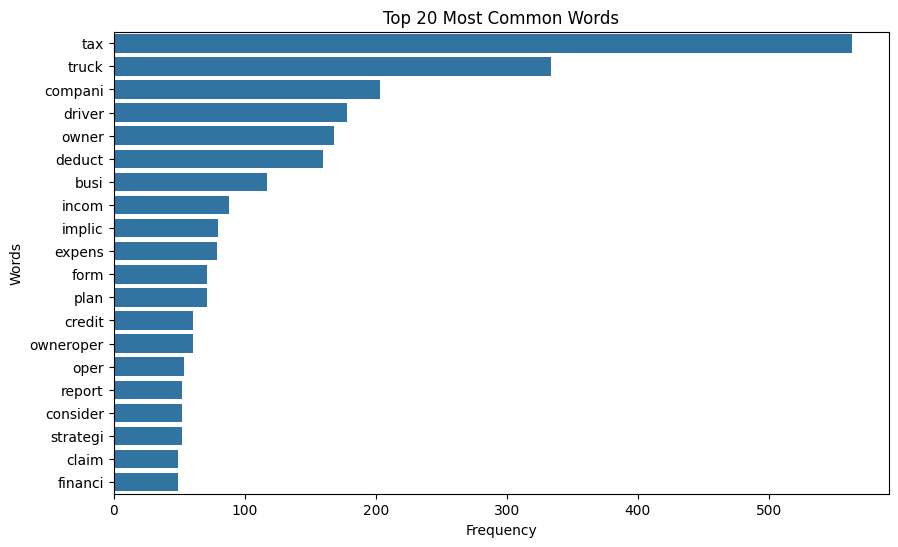

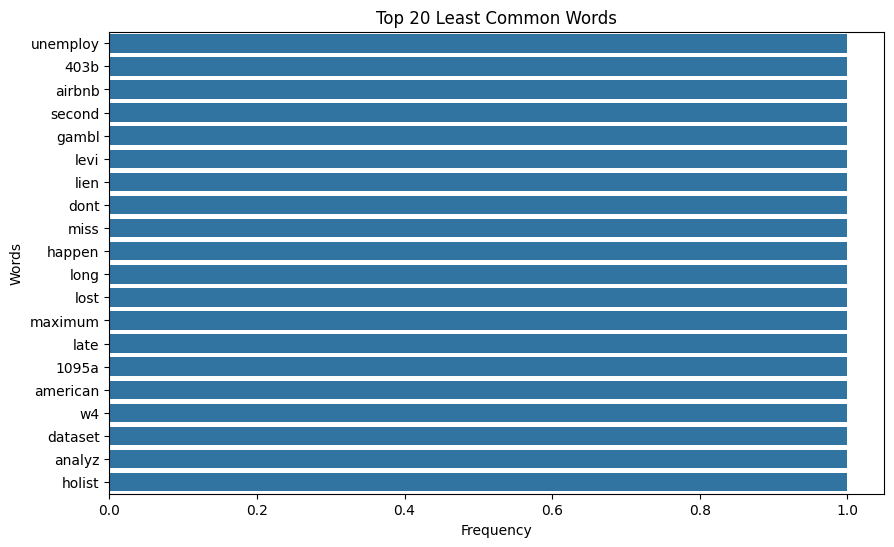

In [ ]:
# Define function to clean text
def preprocess_text(text):

    # Initialize stemmer
    stemmer = PorterStemmer()

    # Text cleanup
    text = text.lower() # Lower case
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation (none words and whitespaces)

    # get a list of english stop words
    stop_words = stopwords.words("english")

    tokens = []
    # remove stop words
    for token in text.split():
        if token not in stop_words:
            stemmed_token = stemmer.stem(token)
            tokens.append(stemmed_token)

    return " ".join(tokens)

# Clean strings
df['question_mod'] = df['input'].apply(preprocess_text)

# tokenize all rows to a single list and perform word count
all_words = ' '.join(df['question_mod']).split()
word_freq = Counter(all_words)
word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)


# Find most and least common 20 words
most_common_words = word_freq[0:20]
least_common_words = word_freq[::-1][:20]

# Plot most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Common Words')
plt.show()

# Plot least common words
words, counts = zip(*least_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Least Common Words')
plt.show()



## 2. Baseline Model: LlaMA-3.2-1B

### 2.0 Load LLaMA and quantize

In [ ]:
# Obtain LLama 3 Key
LLAMA_KEY = userdata.get('LLAMA_KEY')

# Load pre-trained model
model_id = "meta-llama/Llama-3.2-1B-Instruct"  # Replace with the actual model name/path

# Quantize model for lower memory consumption
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,)

llama_base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map='auto',
    quantization_config=quantization_config
)

llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
def generate_answer(prompt, model, tokenizer, max_length=2000, temperature=0.7):
    """
    Generate an answer using LLaMA-3.2-1B.

    Args:
        prompt (str): The input prompt or question.
        model: The LLaMA model.
        tokenizer: The tokenizer for the model.
        max_length (int): The maximum length of the generated output.
        temperature (float): Sampling temperature to control randomness.

    Returns:
        str: The generated answer.
    """
    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt")
    device = next(model.parameters()).device
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

    # Generate output
    outputs = model.generate(
        input_ids = inputs["input_ids"],
        attention_mask = inputs["attention_mask"],
        max_length=max_length,
        temperature=temperature,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode and return the output
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


### 2.1 Construct and Tokenize training/testing Dataset

In [ ]:
# Tokenize dataset for fine-tuning
def tokenize_function(examples):
    """
    Tokenizes, pads, truncates the input and output data for fine-tuning.
    Expects a DatasetDict with columns 'input' and 'output'.

    Args:
    - examples: A batch of examples containing 'input' and 'output' keys.

    Returns:
    - A dictionary with tokenized inputs and aligned labels.
    """
    llama_tokenizer.pad_token = llama_tokenizer.eos_token  # Set pad token to eos token
    llama_tokenizer.truncation_side = "right"

    # Tokenize input (context)
    input_tokenized = llama_tokenizer(
        examples["input"],
        padding="max_length",
        truncation=True,
        max_length=2048, # Need to check for max length!!
        return_tensors="np" # Other types: tensorflow
    )

    # Tokenize output (target/labels)
    output_tokenized = llama_tokenizer(
        examples["output"],
        padding="max_length",
        truncation=True,
        max_length=2048,
        return_tensors="np"
    )

    # Create labels, replacing padding tokens with -100
    labels = output_tokenized["input_ids"]
    labels = [
        [-100 if token == llama_tokenizer.pad_token_id else token for token in label_seq]
        for label_seq in labels
    ]

    # Add labels to the tokenized inputs
    input_tokenized["labels"] = labels

    return input_tokenized


In [ ]:
tokenized_dataset = finetuning_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=80, # Parallel for tokenizing, larger batch size => more memory
    drop_last_batch=True
)
print(tokenized_dataset)

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 640
    })
    valid: Dataset({
        features: ['input', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 80
    })
    test: Dataset({
        features: ['input', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 80
    })
})


In [ ]:
print(finetuning_dataset)

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 689
    })
    valid: Dataset({
        features: ['input', 'output'],
        num_rows: 86
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 87
    })
})


### 2.2 Generating Answers with LLM only - Baseline

In [ ]:
traditional_gen_answers = []
for question in tokenized_dataset['test']['input']:
    answer = generate_answer(question, llama_base_model, llama_tokenizer)
    traditional_gen_answers.append(answer)

In [ ]:
P, R, F1 = score(cands=traditional_gen_answers, refs=finetuning_dataset['test']['output'][:80], lang="en", verbose=False)
metrics_llama = []
for i, (q, p, r, f1) in enumerate(zip(finetuning_dataset['test']['input'], P, R, F1)):
    metrics_llama.append({
        "Sample #": i + 1,
        "Question": q,
        "Precision": float(p),
        "Recall": float(r),
        "F1_Score": float(f1),
    })

metrics_llama = pd.DataFrame(metrics_llama)
metrics_llama.set_index("Sample #", inplace=True)
average_llama = {
    "Question": "Average MiniLLM + FT",
    "Precision": metrics_llama["Precision"].mean(),
    "Recall": metrics_llama["Recall"].mean(),
    "F1_Score": metrics_llama["F1_Score"].mean(),
}
print(average_llama)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Question': 'Average MiniLLM + FT', 'Precision': 0.8241498664021492, 'Recall': 0.8453610114753246, 'F1_Score': 0.8341485127806664}


Test model performance without any Retriever:

## 3 Fine-tuning LlaMa-3.2-1B for text generation in the tax domain

LlaMA-3.2-1B:

*   Fine-tuned, Support Tool-calling
*   lightweight model with text processing capacity only
*   Use Cases by-design: on-device summarization, writing/translation, QA in multiple languages

Fine-tuning Tasks to Perform:
*   LoRA based Question-Answering fine-tuning




In [ ]:
# Set up training arguments
training_args = TrainingArguments(
  learning_rate=1.0e-5,
  num_train_epochs=5,
  #max_steps=1, # Max steps to train for (each step is a batch of data)
  per_device_train_batch_size=3,
  output_dir=file_path,
  disable_tqdm=False, # Disable progress bars
  eval_steps=120, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=5,
  eval_strategy="steps",
  logging_strategy="steps",
  logging_steps=10,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,
  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

# Define LoRA configuration
lora_config = LoraConfig(
    r=16,  # Low-rank dimension
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # Target attention projection layers
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Wrap the quantized model with LoRA
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

# Use lora_model in the Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=llama_tokenizer,
)

# Fine-tune the model
trainer.train()


trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377


<ipython-input-14-5d7cc6d960c6>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
120,9.418500,9.411455
240,8.431100,8.435829


TrainOutput(global_step=265, training_loss=9.684216639680683, metrics={'train_runtime': 2327.1215, 'train_samples_per_second': 1.375, 'train_steps_per_second': 0.114, 'total_flos': 3.799725284052173e+16, 'train_loss': 9.684216639680683, 'epoch': 4.953271028037383})

In [ ]:
# Evaluate the model
metrics = trainer.evaluate(tokenized_dataset["test"])
print(metrics)

{'eval_loss': 8.421406745910645, 'eval_runtime': 26.0776, 'eval_samples_per_second': 3.068, 'eval_steps_per_second': 0.614, 'epoch': 4.953271028037383}


In [ ]:
# Save the model
trainer.save_model(f"{file_path}/fine_tuned_llama")
llama_tokenizer.save_pretrained(f"{file_path}/fine_tuned_llama")

('./content/drive/MyDrive/Berkeley Study/DataSci_266/fine_tuned_llama/tokenizer_config.json',
 './content/drive/MyDrive/Berkeley Study/DataSci_266/fine_tuned_llama/special_tokens_map.json',
 './content/drive/MyDrive/Berkeley Study/DataSci_266/fine_tuned_llama/tokenizer.json')

## 4. Construct the Retrieval-Based Language Model


*   Retriever: embedding model: legal-BERT, all-MiniLM-L6-v2"
*   Web-based Documents: IRS Filing Instructions, Internal Revenue Code (IRC)
*   Generator: SFT LlaMA-3.2-1B

We will add prompt via LangChain pipeline.

### 4.1 Embedding Methods

In [ ]:
# Sentence embedding models
legal_bert_embeddings = HuggingFaceEmbeddings(model_name="jhu-clsp/LegalBert")
minilm_embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

<ipython-input-16-aadc92594f4b>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  legal_bert_embeddings = HuggingFaceEmbeddings(model_name="jhu-clsp/LegalBert")


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 4.2 Retriever with legal-BERT Embedding

In [ ]:
# Loading Context data: Internal Revenue Code (IRC), Court Cases and IRS publication form filing instructions

# Loading IRS form filing instructions
global_doc_number = 1 #assign a unique number to each document we ingest

irs_pubs = ("1040gi", "1040sca", "1065", "1120", "1120s", "8996")
irs_pubs_pages = []

for pub in irs_pubs:
    irs_url = f"https://www.irs.gov/pub/irs-pdf/i{pub}.pdf"

    pub_loader = PyMuPDFLoader(irs_url)
    pub_pages = pub_loader.load()
    for page_num in range(len(pub_pages)):
        page = pub_pages[page_num]
        page.metadata['page_num'] = page_num
        page.metadata['doc_num'] = global_doc_number
        page.metadata['doc_source'] = "IRS_Publications"
        irs_pubs_pages.append(page)

    global_doc_number += 1

num_pages = len(irs_pubs_pages)
num_docs = global_doc_number - 1

print(f"{num_docs} documents in total")
print(f"{num_pages} pages in total")

6 documents in total
293 pages in total


In [ ]:
# Chunking and vectorization
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=25) # Tax documents are usually self-referenced.
splits = text_splitter.split_documents(irs_pubs_pages)
for idx, text in enumerate(splits):
    splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(splits))

# The vector database
qdrant_vectorstore = Qdrant.from_documents(splits,
    legal_bert_embeddings,
    location=":memory:",
    collection_name="rag_tech_db",
    force_recreate=True
)

qdrant_vectorstore.add_documents(documents=splits)

Number of splits/chunks:  3787


['9812e8adf42b48639481f1089034bb8f',
 'e7748c4c03684b4597f9097503f2359a',
 'eb1c7ea3e9194a098a3942b28a949638',
 'f20165e3c1344b06ad2458dafba0e3e6',
 '1e2a1fcc838049a98fac02f66eae6410',
 '2b306e224d3c4b68943977b3792480cb',
 'd9a48c18620c4f0aa2fb9c712fb0b3a9',
 '00c8ea01d5524f9481b847d75cdf3dfe',
 'eac6d07d83d647cf86d059a505ccaadc',
 '0d4bbbb09b1c4033abf0237771cdcbcd',
 '56d35d29eb4f4bc2a03c2961aed8c5ea',
 'fe3983ad6ae44934bc48a1ba82d1a18e',
 'eb00114882cc40a5ad6bb9be544a366b',
 '09fa347d71a445d9b3910f0cc4ce7a43',
 '636d1d69c12a45538b71e491512d4cc1',
 '624416a3539c493f91619bc73e47e8cd',
 'c7121c123ddb44568955d8160cd9da71',
 '7e33f7c0e7da43769b7385d04ac7c46b',
 '3364a021490e4042b2da5f524de3e8fe',
 '32c26d3e23d94ba7b81199bfc6407acc',
 'cfdc14c824494379beab9483721502d3',
 '69d54bd2e2e34be985cda12cc0a465fa',
 '3f2e7e3f7aaa43ac8933805f86d5ee81',
 '4b3d77160d784e8698115fb0f8ac9659',
 'de3f73a6439f4995897c32518f891b8c',
 '58e0aed74e0241b49a83570ca831e86d',
 'a24102911d334cc9b2afa34f8423719a',
 

In [ ]:
# Add IRC subtitle A - Income Tax (Sec 1-1564);
# Subtitle C - Federal Unemployment Tax (Sec 3301, 3306); Subtitle F - Marital Status (Sec 7703)
# to vector database

global_doc_number += 1

irc_sections = ("1", "2", "41", "61", "63", "68", "151", "152", "174", "3301", "3306", "3401", "7701", "7703")
for sec in irc_sections:
  uscode_loader = WebBaseLoader(
      web_paths = [f"https://www.law.cornell.edu/uscode/text/26/{sec}"],
      bs_kwargs=dict(
          parse_only=SoupStrainer(
              class_=("post-content", "post-title", "post-header")
          )
      ),
  )
  uscode_docs = uscode_loader.load()
  for idx, text in enumerate(uscode_docs):
    uscode_docs[idx].metadata['doc_num'] = global_doc_number
    uscode_docs[idx].metadata['doc_source'] = "USCode26"
    global_doc_number += 1
  print('Number of documents: ', len(uscode_docs))

  uscode_splits = text_splitter.split_documents(uscode_docs)

  for idx, text in enumerate(uscode_splits):
    uscode_splits[idx].metadata['split_id'] = idx
  print(f'Number of splits for uscode section {sec}: {len(uscode_splits)}')

  qdrant_vectorstore.add_documents(documents=uscode_splits)



Number of documents:  1
Number of splits for uscode section 1: 0
Number of documents:  1
Number of splits for uscode section 2: 0
Number of documents:  1
Number of splits for uscode section 41: 0
Number of documents:  1
Number of splits for uscode section 61: 0
Number of documents:  1
Number of splits for uscode section 63: 0
Number of documents:  1
Number of splits for uscode section 68: 0
Number of documents:  1
Number of splits for uscode section 151: 0
Number of documents:  1
Number of splits for uscode section 152: 0
Number of documents:  1
Number of splits for uscode section 174: 0
Number of documents:  1
Number of splits for uscode section 3301: 0
Number of documents:  1
Number of splits for uscode section 3306: 0
Number of documents:  1
Number of splits for uscode section 3401: 0
Number of documents:  1
Number of splits for uscode section 7701: 0
Number of documents:  1
Number of splits for uscode section 7703: 0


In [ ]:
global_doc_number += 1

# Loading turbotax educational articles on tax planning and add to vector database
turbo_loader = WebBaseLoader(
    web_paths=("https://turbotax.intuit.com/tax-tips/self-employment-taxes/what-you-need-to-know-about-truck-driver-tax-deductions/L68YC61fS",
               "https://turbotax.intuit.com/tax-tips/self-employment-taxes/self-employment-tax-vs-income-tax---whats-the-difference/c6xs5Yg5j",
               ),

    bs_kwargs=dict(
        parse_only=SoupStrainer(
            class_=("fixed-width gutters")
        )
    ),
)

turbo_documents = turbo_loader.load()

for idx, text in enumerate(turbo_documents):
    turbo_documents[idx].metadata['doc_num'] = global_doc_number
    turbo_documents[idx].metadata['doc_source'] = "WWW"
    global_doc_number += 1

print('Number of documents: ', len(turbo_documents))

turbo_splits = text_splitter.split_documents(turbo_documents)

for idx, text in enumerate(turbo_splits):
    turbo_splits[idx].metadata['split_id'] = idx

print('Number of splits for turbotax article: ', len(turbo_splits))
qdrant_vectorstore.add_documents(documents=turbo_splits)

Number of documents:  2
Number of splits for turbotax article:  0


[]

In [ ]:
url = "https://taxpolicycenter.org/briefing-book/what-are-opportunity-zones-and-how-do-they-work"
loader = WebBaseLoader(
    web_paths=(url,),
    bs_kwargs=dict(
        parse_only=SoupStrainer("div", id="block-lyndon-content")  # Customize based on the article's content structure
    ),
)

# Load the document
other_documents = loader.load()

for idx, text in enumerate(other_documents):
    other_documents[idx].metadata['doc_num'] = global_doc_number
    other_documents[idx].metadata['doc_source'] = "WWW"
    global_doc_number += 1

print('Number of documents: ', len(other_documents))

# Split with research64 & marketing 128
other_splits = text_splitter.split_documents(other_documents)

for idx, text in enumerate(other_splits):
    other_splits[idx].metadata['split_id'] = idx

print('Number of splits for turbotax article: ', len(other_splits))
qdrant_vectorstore.add_documents(documents=other_splits)

Number of documents:  1
Number of splits for turbotax article:  32


['4cd95b20c2244c54b6a7559cf7ac875f',
 '4c32acdbc12f41ccb3f8db2b5fec14f9',
 'eccbb1cd13074adba1ff761b043a678a',
 'f7d9ef1dd63e41808c1fe7142e2bcfdf',
 'c887f67499394626b70d220a4790eddd',
 '1305a95a522d4a6c94507c76c42b2c49',
 '7e4ae62571154e2294396f56e8295d19',
 'c4af404140ed47bf93aa2184e94addd9',
 'fa7a1f0209154e928bbd6af674817e46',
 'a11d6f4d50f54b288797cb8b65e1741f',
 '97e8e29fd31b452ea4e8151f8b1c8323',
 '68827751f53c4b6fa01e8d9cee8ebf2e',
 'ef68e2c3fb884e77a79c4661dc8d12ec',
 '3477b9145c6b4740bad0f89bf59ce1ee',
 '057e01c363de4d39b07a0baacf92d88e',
 'e66775645e2547b3bb3c9dcd10c7db6f',
 '5b0c6ab39d044e0490fd5ec83d76dd24',
 '5be2ef8e3be949868e2bdacc277ac56b',
 'ff1a38dd3b454b4f83f17eaa923c0a29',
 'c3114eb9201f4b439ec77313dad9c233',
 '0de79c3ceabb49e7bbeac4623f9a589c',
 '66002588b8814b54888e17aadd9af77d',
 '9df1ae04da554cb1b79ee60b5b8a4c99',
 '97d7f3cb50154d0cad8f275ee5f4361b',
 '7d685a9b8ff34c72a2509593242a7c75',
 '0276a03c7aee4022bb4687bf495413c0',
 'ab385d166cb5454997b96edce5f85d13',
 

In [ ]:
# Load Retriever
retriever = qdrant_vectorstore.as_retriever()

### 4.3 Retriever with "all-MiniLM-L6-v2" Embedding

In [ ]:

global_doc_number = 1 #assign a unique number to each document we ingest

irs_pubs = ("1040gi", "1040sca", "1065", "1120", "1120s", "8996")
irs_pubs_pages = []

for pub in irs_pubs:
    irs_url = f"https://www.irs.gov/pub/irs-pdf/i{pub}.pdf"

    pub_loader = PyMuPDFLoader(irs_url)
    pub_pages = pub_loader.load()
    for page_num in range(len(pub_pages)):
        page = pub_pages[page_num]
        page.metadata['page_num'] = page_num
        page.metadata['doc_num'] = global_doc_number
        page.metadata['doc_source'] = "IRS_Publications"
        irs_pubs_pages.append(page)

    global_doc_number += 1

num_pages = len(irs_pubs_pages)
num_docs = global_doc_number - 1

print(f"{num_docs} documents in total")
print(f"{num_pages} pages in total")

6 documents in total
293 pages in total


In [ ]:
# Loaded IRS form filing instructions in the last section
# Chunking and vectorization
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=25) # The same parameters
splits = text_splitter.split_documents(irs_pubs_pages)
for idx, text in enumerate(splits):
    splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(splits))

# The vector database
qdrant_vectorstore_minilm = Qdrant.from_documents(splits,
    minilm_embedding,
    location=":memory:",
    collection_name="rag_tech_db",
    force_recreate=True
)

qdrant_vectorstore_minilm.add_documents(documents=splits)

Number of splits/chunks:  3787


['2cdb3a2a960649248c548e1a59fc222a',
 '819c550112bc454bb59a2637197a6b90',
 'a75d2912334d49eb822f56a581c840ee',
 '768bab05733a4f169a406577b3369e05',
 '2a1858c213c348a9a2fddc0ddaa3988e',
 'b0de4bdd5deb44f08f00501a352d1e9b',
 '7c096d74fdcb4d11bde6494f4fe0f8cd',
 '30027c403864442eaa166469d1e80d7b',
 '38f7c09494284df68c07877ecefa77ef',
 '3ab621d3738e41598c96e8b1b48fea52',
 'ec9593ff029f4025a3a0e48aede68ff6',
 '1b732f7820784a34bdc910a1de7c40b5',
 '56e6f92c2cd24bc8b9461d0724aecf4b',
 'a4c6af4ed1e84c75a7e46fb86f4cb86e',
 '2a34559b04394f25bf1077409af4ca67',
 'cb205f69ba8e4bcdad27faf857e0efad',
 '4381757c6c544126af8d8757f3ad65cd',
 'c688588f1d824eeaa1d3139616c0f535',
 '5f0f57221768471f8f99c556ca817ea1',
 'ac1cc2c8c74a44b99bdd421f36dd6ff1',
 '3e328003f4734dcda30405929cddff54',
 'd41ae5ff67134097886b278ae5cf854c',
 '7c3a3e9b8d924567b17a43ef5088d8a9',
 'ff6739926c1344dcb3e4bae3edccee7a',
 '7745969f00e74dabb4be0177393fe4c9',
 'daae90bb9aff404abbda95f60019f416',
 'c77039e4430741fda149ea9f5cf27df6',
 

In [ ]:
# Add IRC subtitle A - Income Tax (Sec 1-1564);
# Subtitle C - Federal Unemployment Tax (Sec 3301, 3306); Subtitle F - Marital Status (Sec 7703)
# to vector database

global_doc_number += 1

irc_sections = ("1", "2", "41", "61", "63", "68", "151", "152", "174", "3301", "3306", "3401", "7701", "7703")
for sec in irc_sections:
  uscode_loader = WebBaseLoader(
      web_paths = [f"https://www.law.cornell.edu/uscode/text/26/{sec}"],
      bs_kwargs=dict(
          parse_only=SoupStrainer(
              class_=("section", "tab-content", "title")
          )
      ),
  )
  uscode_docs = uscode_loader.load()
  for idx, text in enumerate(uscode_docs):
    uscode_docs[idx].metadata['doc_num'] = global_doc_number
    uscode_docs[idx].metadata['doc_source'] = "USCode26"
    global_doc_number += 1
  print('Number of documents: ', len(uscode_docs))

  uscode_splits = text_splitter.split_documents(uscode_docs)

  for idx, text in enumerate(uscode_splits):
    uscode_splits[idx].metadata['split_id'] = idx
  print(f'Number of splits for uscode section {sec}: {len(uscode_splits)}')

  qdrant_vectorstore_minilm.add_documents(documents=uscode_splits)

Number of documents:  1
Number of splits for uscode section 1: 655
Number of documents:  1
Number of splits for uscode section 2: 38
Number of documents:  1
Number of splits for uscode section 41: 257
Number of documents:  1
Number of splits for uscode section 61: 45
Number of documents:  1
Number of splits for uscode section 63: 78
Number of documents:  1
Number of splits for uscode section 68: 19
Number of documents:  1
Number of splits for uscode section 151: 60
Number of documents:  1
Number of splits for uscode section 152: 85
Number of documents:  1
Number of splits for uscode section 174: 25
Number of documents:  1
Number of splits for uscode section 3301: 23
Number of documents:  1
Number of splits for uscode section 3306: 254
Number of documents:  1
Number of splits for uscode section 3401: 125
Number of documents:  1
Number of splits for uscode section 7701: 339
Number of documents:  1
Number of splits for uscode section 7703: 9


In [ ]:
global_doc_number += 1

# Loading turbotax educational articles on tax planning and add to vector database
turbo_loader = WebBaseLoader(
    web_paths=("https://turbotax.intuit.com/tax-tips/self-employment-taxes/what-you-need-to-know-about-truck-driver-tax-deductions/L68YC61fS",
               "https://turbotax.intuit.com/tax-tips/self-employment-taxes/self-employment-tax-vs-income-tax---whats-the-difference/c6xs5Yg5j"
               ),

    bs_kwargs=dict(
        parse_only=SoupStrainer(
            class_=("fixed-width gutters")
        )
    ),
)

turbo_documents = turbo_loader.load()

for idx, text in enumerate(turbo_documents):
    turbo_documents[idx].metadata['doc_num'] = global_doc_number
    turbo_documents[idx].metadata['doc_source'] = "WWW"
    global_doc_number += 1

print('Number of documents: ', len(turbo_documents))

# Split with research64 & marketing 128
turbo_splits = text_splitter.split_documents(turbo_documents)

for idx, text in enumerate(turbo_splits):
    turbo_splits[idx].metadata['split_id'] = idx

print('Number of splits for turbotax article: ', len(turbo_splits))
qdrant_vectorstore_minilm.add_documents(documents=turbo_splits)

Number of documents:  2
Number of splits for turbotax article:  0


[]

In [ ]:
url = "https://taxpolicycenter.org/briefing-book/what-are-opportunity-zones-and-how-do-they-work"
loader = WebBaseLoader(
    web_paths=(url,),
    bs_kwargs=dict(
        parse_only=SoupStrainer("div", id="block-lyndon-content")  # Customize based on the article's content structure
    ),
)

# Load the document
other_documents = loader.load()

for idx, text in enumerate(other_documents):
    other_documents[idx].metadata['doc_num'] = global_doc_number
    other_documents[idx].metadata['doc_source'] = "WWW"
    global_doc_number += 1

print('Number of documents: ', len(other_documents))

# Split with research64 & marketing 128
other_splits = text_splitter.split_documents(other_documents)

for idx, text in enumerate(other_splits):
    other_splits[idx].metadata['split_id'] = idx

print('Number of splits for turbotax article: ', len(other_splits))
qdrant_vectorstore_minilm.add_documents(documents=other_splits)


Number of documents:  1
Number of splits for turbotax article:  32


['4d2724197b9846f483151e9261cb4770',
 '127581af3c674b4788a0456a884a08ca',
 '1d42073888604c03955859a6a1c2ac5c',
 '6b5cd2c2a17a4c338331297125aafdd7',
 '5c348c2f46c9490c9ad7f189f4ffd575',
 '17cf8d367f924543a570f498452b709c',
 '060d659f86b5469b8e7a42292ec464da',
 '993b95c68f1c46adadbad7a705d07bd4',
 'f7331da327a84f2792572df5702a9097',
 '5e8dfa463f4b4bcb8c58dcc059656d1f',
 'fdb30017a6da4781badaa726667127e5',
 '37654a8fc4ee415d8bb4291ddc57fbe0',
 '107ad258ecc54cb88db4a25f25f8280f',
 '84cdb6bfd8a94db4ae148e021769ae9c',
 '98a26358a206431f83b61ffe07c7fc6b',
 '54e666a5c98243969817dc93a1b60f2c',
 '28840bdfea5b4c238be62fe9c07db411',
 '2847d40728e54250b2e4db6f3117ebef',
 'f4b32e4ad83245279298be4468ba57e4',
 '3dabfbfd0bf240ad9d82c1a823c2d24b',
 '9ceac1ce488e45db9a30a6523dcb2bf2',
 '39a83f97df1944aaa955476e0460fac1',
 '79929d116c744c5e8fd71b2910dbfaa0',
 'b11e621e1a374b7fa5f8a88c824d47b4',
 '4b8f984b947d430495150fe49d3986e5',
 '2243e0027225487898bb83b8a6d7c4c5',
 '414600581f87461792648e7de3744ab6',
 

In [ ]:
retriever_minilm = qdrant_vectorstore_minilm.as_retriever()

### 4.4 Generator Model with baseline llama-3.2

In [ ]:
# Base LlaMA hyper-parameters to begain with:
base_pipe = pipeline(
    "text-generation",
    model=llama_base_model, # Model before fine-tuning
    tokenizer=llama_tokenizer,
    max_new_tokens=1500,
    temperature=0.9, # Experimented on 0.8, 0.6, 0.3
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.2
)
base_pipe.model.config.pad_token_id = base_pipe.model.config.eos_token_id

# Wrap the model into a LangChain pipeline object
base_lc = HuggingFacePipeline(pipeline=base_pipe)

<ipython-input-29-abbedb41a453>:15: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  base_lc = HuggingFacePipeline(pipeline=base_pipe)


### 4.5 Generator Model with FT llama-3.2

In [ ]:
load_directory = f"{file_path}/fine_tuned_llama"
llama_model_ft = AutoModelForCausalLM.from_pretrained(load_directory)
llama_tokenizer_ft = AutoTokenizer.from_pretrained(load_directory)

# Base LlaMA hyper-parameters to begain with:
llama_pipe_ft = pipeline(
    "text-generation",
    model=llama_model_ft,
    tokenizer=llama_tokenizer_ft,
    max_new_tokens=1500,
    temperature=0.9, # Experimented on 0.8, 0.6, 0.3
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.2,
    device_map="auto"
)
llama_pipe_ft.model.config.pad_token_id = llama_pipe_ft.model.config.eos_token_id

# Wrap the model into a LangChain pipeline object
llama_lc = HuggingFacePipeline(pipeline=llama_pipe_ft)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


### 4.6 RAG pipelines

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def capture_context(context):
    global retrieved_context
    retrieved_context = context
    return context

from langchain.schema import BaseOutputParser
'''
class CleanOutputParser(BaseOutputParser):
    def parse(self, text: str) -> str:
        prompt_language = '[INST]\nAct like a professional tax consultant to answer the question below in less than 5 sentences only based on the context.\nDo not include the question in your answer.\n{context}\nquestion: {question}\n[/INST]'
        cleaned_output = text.strip(prompt_language)

        if retrieved_context in cleaned_output:
            cleaned_output = cleaned_output.split(retrieved_context)[0].strip()
        if prompt_language in cleaned_output:
            cleaned_output = cleaned_output.split(prompt_language)[0].strip()

        return cleaned_output
'''

In [ ]:
# Build RAG pipeline

rag_template = """[INST]
Act like a professional tax consultant to answer the question below in less than 5 sentences only based on the context.
Do not include the question in your answer.
{context}
question: {question}
[/INST]"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)
output_parser = StrOutputParser()
#output_parser = CleanOutputParser()

rag_chain_base = (
    {"context": retriever | format_docs | capture_context,
     "question": RunnablePassthrough()}
    | rag_prompt
    | base_lc
    | output_parser
)

rag_chain_ft = (
    {"context": retriever | format_docs | capture_context,
     "question": RunnablePassthrough()}
    | rag_prompt
    | llama_lc
    | output_parser
)

rag_chain_base_minillm = (
    {"context": retriever_minilm | format_docs | capture_context,
     "question": RunnablePassthrough()}
    | rag_prompt
    | base_lc
    | output_parser
)

rag_chain_ft_minillm = (
    {"context": retriever_minilm | format_docs | capture_context,
     "question": RunnablePassthrough()}
    | rag_prompt
    | llama_lc
    | output_parser
)

## 5. Quantitative Evaluation

*   BERTScore (semantic similarity)
*   Perplexity (fluency and coherence)
*   Human Evaluation for Faithfullness








In [ ]:
# Execute dataset on testing subset
def execute_rag(rag_chain, test_dataset):
  ''' Execute the rag pipeline to take the list of test questions and return a dictionary of lists of questions and answers.'''
  generated_answers = []
  contexts = []

  for question in test_dataset['test']['input']:
    resp = rag_chain.invoke(question)
    generated_answers.append(resp)
    contexts.append(retrieved_context)

  return {"questions": test_dataset['test']['input'], "generated_answers": generated_answers, "retrieved_contexts": contexts, "reference_answers" : test_dataset['test']['output']}

### 5.0 RAGAS Framework:

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4


In [ ]:
import openai
from bert_score import score as bert_score
openai.api_key = "ADD_YOUR_OPENAI_API_KEY"

In [ ]:
def calculate_ragas(queries, retrieved_contexts, generated_answers, reference_answers, weights=None):
  if weights is None:
        weights = {"context_relevancy": 1/3, "faithfulness": 1/3, "answer_relevancy": 1/3}

  scores = {"context_relevancy": [], "faithfulness": [], "answer_relevancy": []}

  i=1
  for query, context, generated, reference in zip(queries, retrieved_contexts, generated_answers, reference_answers):

    # Evaluate context relevancy
    context_prompt = f"""
        Evaluate the relevance of the retrieved context to the following query:
        Query: {query}
        Retrieved Context: {context}
        Rate the relevance on a scale of 1 (irrelevant) to 5 (highly relevant).
        """
    context_response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an evaluator for RAG models."},
            {"role": "user", "content": context_prompt}
        ]
    )
    content = context_response.choices[0].message.content.strip().replace('"', '')
    #display(content)
    pattern = r"\b([1-5])\b"
    match = re.search(pattern, content)
    if match:
      context_score = int(match.group(1))
    else:
      context_score = 0
    scores["context_relevancy"].append(context_score)
    #print(f'Context Relevancy Score for question {i}: {context_score}\n~~~~~~~~')

    # Evaluate answer faithfulness
    faithfulness_prompt = f"""
        Assess whether the following answer is faithful to the retrieved context:
        Retrieved Context: {context}
        Generated Answer: {generated}
        Rate the faithfulness on a scale of 1 (not faithful) to 5 (completely faithful).
        """
    faithfulness_response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an evaluator for RAG models."},
            {"role": "user", "content": faithfulness_prompt}
        ]
    )
    faith_content = faithfulness_response.choices[0].message.content.strip().replace('"', '')
    #display(faith_content)
    faith_pattern = r"\b([1-5])\b"

    match = re.search(faith_pattern, faith_content)
    if match:
      faithfulness_score = int(match.group(1))
    else:
      faithfulness_score = 0
    scores["faithfulness"].append(faithfulness_score)
    #print(f'Faithfulness Score for question {i}: {faithfulness_score}\n~~~~~~~~')

    # Evaluate the generated answer relevancy
    relevancy_prompt = f"""
        Compare the following generated answer to the reference answer for relevance and correctness:
        Query: {query}
        Generated Answer: {generated}
        Reference Answer: {reference}
        Rate the relevance on a scale of 1 (irrelevant) to 5 (highly relevant).
        """
    relevancy_response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an evaluator for RAG models."},
            {"role": "user", "content": relevancy_prompt}
        ]
    )
    relevancy_content = relevancy_response.choices[0].message.content.strip().replace('"', '')
    #display(relevancy_content)
    relevancy_pattern = r"\b([1-5])\b"
    match = re.search(relevancy_pattern, relevancy_content)
    if match:
      relevancy_score = int(match.group(1))
    else:
      relevancy_score = 0
    scores["answer_relevancy"].append(relevancy_score)
    #print(f'Answer Relevancy Score for question {i}: {relevancy_score}\n~~~~~~~~')
    #i+=1
    #if i >= 4:
    #  break
  #print(scores)
  avg_scores = {metric: round(sum(values) / len(values),2) for metric, values in scores.items()}
  bert_scores = bert_score(generated_answers, reference_answers, lang="en")[2].mean().item()
  ragas_score = sum(avg_scores[metric] * weights[metric] for metric in avg_scores)

  return {"scores": avg_scores, "bert_score": bert_scores, "ragas_score": ragas_score}


### 5.1 legal-BERT + base llama-3.2

In [ ]:
res_base = execute_rag(rag_chain_base, finetuning_dataset)

gen_answers = res_base['generated_answers']
ref_answers = res_base['reference_answers']
ques_samples = res_base['questions']
context_base = res_base['retrieved_contexts']

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Evaluation with RAGAS and BERTScore
print(calculate_ragas(ques_samples, context_base, gen_answers, ref_answers))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'scores': {'context_relevancy': 1.45, 'faithfulness': 1.53, 'answer_relevancy': 2.01}, 'bert_score': 0.8071104884147644, 'ragas_score': 1.663333333333333}


In [ ]:
'''
# Showing Breakdown of BERTScore: Precision, Recall, F1 Score
P, R, F1 = score(cands=gen_answers, refs=ref_answers, lang="en", verbose=False)

metrics_tax = []
for i, (q, p, r, f1) in enumerate(zip(ques_samples, P, R, F1)):
    metrics_tax.append({
        "Sample #": i + 1,
        "Question": q,
        "Precision": float(p),
        "Recall": float(r),
        "F1_Score": float(f1),
    })

metrics_df = pd.DataFrame(metrics_tax)
metrics_df.set_index("Sample #", inplace=True)
average_row1 = {
    "Question": "Average Legal-BERT without FT",
    "Precision": metrics_df["Precision"].mean(),
    "Recall": metrics_df["Recall"].mean(),
    "F1_Score": metrics_df["F1_Score"].mean(),
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([average_row1], index=["Base_legalbert_Average"])])

print(f'BERTScores:\n')
display(metrics_df)
'''

### 5.2 legal-BERT + FT llama-3.2

In [ ]:
# Execute RAG on test dataset
res_ft = execute_rag(rag_chain_ft, finetuning_dataset)


In [ ]:
gen_answers_ft = res_ft['generated_answers']
ref_answers_ft = res_ft['reference_answers']
ques_samples_ft = res_ft['questions']
context_ft = res_ft['retrieved_contexts']

print(calculate_ragas(ques_samples_ft, context_ft, gen_answers_ft, ref_answers_ft))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'scores': {'context_relevancy': 1.49, 'faithfulness': 1.67, 'answer_relevancy': 2.26}, 'bert_score': 0.8071104884147644, 'ragas_score': 1.8066666666666664}


In [ ]:
'''
# Showing Breakdown of BERTScore: Precision, Recall, F1 Score
P, R, F1 = score(cands=gen_answers_ft, refs=ref_answers_ft, lang="en", verbose=False)
metrics_tax_ft = []
for i, (q, p, r, f1) in enumerate(zip(ques_samples_ft, P, R, F1)):
    metrics_tax_ft.append({
        "Sample #": i + 1,
        "Question": q,
        "Precision": float(p),
        "Recall": float(r),
        "F1_Score": float(f1),
    })

metrics_df_ft = pd.DataFrame(metrics_tax_ft)
metrics_df_ft.set_index("Sample #", inplace=True)
average_row2 = {
    "Question": "Average Legal-BERT + FT",
    "Precision": metrics_df_ft["Precision"].mean(),
    "Recall": metrics_df_ft["Recall"].mean(),
    "F1_Score": metrics_df_ft["F1_Score"].mean(),
}

# Also append the metrics of fine-tuned llama to metrics_df
metrics_df = pd.concat([metrics_df, pd.DataFrame([average_row2], index=["FT_legalbert_Average"])])

print(f'BERTScores:\n')
display(metrics_df.tail(2))
'''

### 5.3 MiniLLM + base llama-3.2

In [ ]:
res_llm_base = execute_rag(rag_chain_base_minillm, finetuning_dataset)


In [ ]:
gen_answers_llm = res_llm_base['generated_answers']
ref_answers_llm = res_llm_base['reference_answers']
ques_samples_llm = res_llm_base['questions']
context_llm = res_llm_base['retrieved_contexts']

print(calculate_ragas(ques_samples_llm, context_llm, gen_answers_llm, ref_answers_llm))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'scores': {'context_relevancy': 1.92, 'faithfulness': 1.61, 'answer_relevancy': 2.18}, 'bert_score': 0.8071104884147644, 'ragas_score': 1.9033333333333333}


In [ ]:
'''
# Showing Breakdown of BERTScore: Precision, Recall, F1 Score
P, R, F1 = score(cands=gen_answers_llm, refs=ref_answers_llm, lang="en", verbose=False)

metrics_tax_llm = []
for i, (q, p, r, f1) in enumerate(zip(ques_samples_llm, P, R, F1)):
    metrics_tax_llm.append({
        "Sample #": i + 1,
        "Question": q,
        "Precision": float(p),
        "Recall": float(r),
        "F1_Score": float(f1),
    })

metrics_df_llm = pd.DataFrame(metrics_tax_llm)
metrics_df_llm.set_index("Sample #", inplace=True)
average_row3 = {
    "Question": "Average MiniLLM without FT",
    "Precision": metrics_df_llm["Precision"].mean(),
    "Recall": metrics_df_llm["Recall"].mean(),
    "F1_Score": metrics_df_llm["F1_Score"].mean(),
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([average_row3], index=["Base_minillm_Average"])])

print(f'BERTScores:\n')
display(metrics_df.tail(3))
'''

### 5.4 MiniLLM + FT llama-3.2

In [ ]:
res_llm_ft = execute_rag(rag_chain_ft_minillm, finetuning_dataset)

In [ ]:
gen_answers_llm_ft = res_llm_ft['generated_answers']
ref_answers_llm_ft = res_llm_ft['reference_answers']
ques_samples_llm_ft = res_llm_ft['questions']
context_llm_ft = res_llm_ft['retrieved_contexts']

In [ ]:
print(calculate_ragas(ques_samples_llm_ft, context_llm_ft, gen_answers_llm_ft, ref_answers_llm_ft))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'scores': {'context_relevancy': 1.92, 'faithfulness': 1.63, 'answer_relevancy': 1.29}, 'bert_score': 0.7905036807060242, 'ragas_score': 1.613333333333333}


In [ ]:
'''
# Showing Breakdown of BERTScore: Precision, Recall, F1 Score
P, R, F1 = score(cands=gen_answers_llm_ft, refs=ref_answers_llm_ft, lang="en", verbose=False)
metrics_tax_llm_ft = []
for i, (q, p, r, f1) in enumerate(zip(ques_samples_llm_ft, P, R, F1)):
    metrics_tax_llm_ft.append({
        "Sample #": i + 1,
        "Question": q,
        "Precision": float(p),
        "Recall": float(r),
        "F1_Score": float(f1),
    })

metrics_df_llm_ft = pd.DataFrame(metrics_tax_llm_ft)
metrics_df_llm_ft.set_index("Sample #", inplace=True)
average_row4 = {
    "Question": "Average MiniLLM + FT",
    "Precision": metrics_df_llm_ft["Precision"].mean(),
    "Recall": metrics_df_llm_ft["Recall"].mean(),
    "F1_Score": metrics_df_llm_ft["F1_Score"].mean(),
}

# Also append the metrics of fine-tuned llama to metrics_df
metrics_df = pd.concat([metrics_df, pd.DataFrame([average_row4], index=["FT_minillm_Average"])])
metrics_df.tail(4)
'''

## 6. Save metrics file to google drive

In [ ]:
# Save the initial metrics
summary_df = pd.DataFrame(columns=["Question", "Precision", "Recall", "F1_Score"])

summary_df = pd.concat([summary_df, metrics_df.loc[['Base_legalbert_Average', 'FT_legalbert_Average', 'Base_minillm_Average', 'FT_minillm_Average']]])
summary_df = summary_df.reset_index(drop=True)
display(summary_df)
summary_df.to_csv(f'{file_path}/metrics_summary.csv', index=False)

<ipython-input-42-da398bc5587b>:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, metrics_df.loc[['Base_legalbert_Average', 'FT_legalbert_Average', 'Base_minillm_Average', 'FT_minillm_Average']]])


,Question,Precision,Recall,F1_Score
0,Average Legal-BERT without FT,0.777360,0.820222,0.797983
1,Average Legal-BERT + FT,0.777377,0.820206,0.797984
2,Average MiniLLM without FT,0.765869,0.817580,0.790459
3,Average MiniLLM + FT,0.765645,0.817529,0.790313


## Manually check for answers:

In [ ]:
#for question in finetuning_dataset['test']['input'][10:20]:
#  print(question, "\n~~~~~~~~~\n")
finetuning_dataset['test']['input'][10]

' What are the tax benefits associated with investing in Opportunity Zones?  '

In [ ]:
#for gold in finetuning_dataset['test']['output'][10:20]:
#  print(gold, "\n~~~~~~~~~\n")
print(finetuning_dataset['test']['output'][10])

Investing in Opportunity Zones can offer several tax benefits, which are designed to encourage economic growth and investment in designated underdeveloped areas. Here are the key tax advantages:

1. **Deferral of Capital Gains Taxes**: If you invest a capital gain in a Qualified Opportunity Fund (QOF) within 180 days of realizing the gain, you can defer paying taxes on that gain until you sell your investment in the QOF or December 31, 2026, whichever comes first.

2. **Reduction of Capital Gains Taxes**: If you hold your investment in the QOF for at least 5 years, you can reduce the taxable amount of the deferred gain by 10%. If held for 7 years, this reduction increases to 15%.

3. **Exclusion of Capital Gains from New Investment**: For investments held in the QOF for at least 10 years, you may qualify for an exclusion from taxes on any new gains accrued from the QOF investment.

To maximize these benefits and ensure compliance with the complex requirements, it's crucial to keep accu

llama-3.2-1B

In [ ]:
#for question in traditional_gen_answers[10:20]:
#  print(question, "\n~~~~~~~~\n")
print(traditional_gen_answers[10])

 What are the tax benefits associated with investing in Opportunity Zones?   The following tax benefits are available to investors who are seeking to invest in Opportunity Zones:
- 100% pass-through tax benefits: The investment is passed through to the investors as a pass-through tax benefit, meaning that it will be taxed at the investor's ordinary income tax rate.
- 100% pass-through tax benefits: The investment is passed through to the investors as a pass-through tax benefit, meaning that it will be taxed at the investor's ordinary income tax rate.
- 100% pass-through tax benefits: The investment is passed through to the investors as a pass-through tax benefit, meaning that it will be taxed at the investor's ordinary income tax rate.
- 100% pass-through tax benefits: The investment is passed through to the investors as a pass-through tax benefit, meaning that it will be taxed at the investor's ordinary income tax rate.
- 100% pass-through tax benefits: The investment is passed throug

RAG: legal-BERT + llama-3.2-1B

In [ ]:
#for ans in gen_answers[10:20]:
#  print(ans, "\n~~~~~~~~\n")
print(gen_answers[10])

Human: [INST]
Act like a professional tax consultant to answer the question below in less than 5 sentences only based on the context.
Do not include the question in your answer.


RAG: legal-BERT + llama-3.2-1B FT

In [ ]:
#for question in gen_answers_ft[10:20]:
  #print(question, "\n~~~~~~~~\n")
print(gen_answers_ft[10])

Human: [INST]
Act like a professional tax consultant to answer the question below in less than 5 sentences only based on the context.
Do not include the question in your answer.


RAG: MiniLLM + llama-3.2-1B

In [ ]:
#for question in gen_answers_llm[10:20]:
#  print(question, "\n~~~~~~~~\n")
print(gen_answers_llm[10])

Human: [INST]
Act like a professional tax consultant to answer the question below in less than 5 sentences only based on the context.
Do not include the question in your answer.


RAG: MiniLLM + llama-3.2-1B FT

In [ ]:
#for question in gen_answers_llm_ft[10:20]:
#  print(question, "\n~~~~~~~~\n")
print(gen_answers_llm_ft[10])

Human: [INST]
Act like a professional tax consultant to answer the question below in less than 5 sentences only based on the context.
Do not include the question in your answer.
allows, $1 in $10 of investment actually happens outside of zones, including higher-income communities. Generally, Opportunity Zones benefit a “narrow subset of tracts in which economic conditions were already improving prior to implementation of the tax subsidy,” as per the Joint Committee on Taxation report.

Opportunity Zone tax incentives can be used for commercial and industrial real estate, housing, infrastructure, and existing or start-up business investments. For real estate projects to qualify for the tax incentives, the investment must result in the properties being “substantially improved.”

How do Opportunity Zones Work?
The 2017 Tax Cuts and Jobs Act created the Opportunity Zones program—meant to spur investment in undercapitalized communities.
The program provided three tax benefits for investing 